<code>plot_RMSE_all_days_ALL_YEAR.ipynb</code> plots RMSE as a function of lead time for ALL DAYS for all S2S models.

In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from S2S_sea_ice_plotting import RMSE_plot

### Inputs:
* <code>model_names</code>: which models to include (helpful for debugging)
* <code>seas_str</code>: which season to plot (string) (for this notebook, we'll just do ALL)
* <code>seas_sel</code>: months to include (array) (all months for this notebook)
* <code>vrile_thresh</code>: threshold for VRILE calculation (string)
* <code>clim_freq</code>: lead time in days or weeks (string)
* <code>TO_PLOT</code>: are we plotting SIE or SIE anom?
* <code>obs_name</code>: which set of obs to use (string)
* <code>obs_name_plt</code>: name of obs (for plot, string)
* <code>ALL_DAYS</code>: boolean; if true, include VRILE and nonVRILE days; if false, just use nonVRILE days

In [2]:
ALL_REGIONS = False 
model_names = ['ecmwf','ukmo','metreofr','ncep','DAMPED_ANOMALY']
#model_names = ['DAMPED_ANOMALY']
seas_str_ALL = ['JFM','JJA']
seas_sel = [1,2,3,4,5,6,7,8,9,10,11,12]
vrile_thresh = '05'
clim_freq = 'WEEKLY'
TO_PLOT = 'SIE anom RMSE'
obs_name = 'NSIDC_0079'
obs_name_plt = 'NASA Bootstrap'
ALL_DAYS = True

### Steps
1. Load on RMSE spreadsheets for all days and VRILE days, and combine all models into one spreadsheet 
2. Plot RMSE vs lead time for specified season for desired regions. 

Load <code>.csv</code> files

In [3]:
d_SIE_all = pd.DataFrame()
fpath_load = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/data/'
for seas_str in seas_str_ALL:
    for i_model in model_names:
        # Damped anomaly has different filename
        if i_model == 'DAMPED_ANOMALY':
            fpath_all = fpath_load+'{model_name}_{obs_name}/OBS_{obs_name}/'.format(model_name=i_model,obs_name=obs_name)       
            fpath_all = fpath_all+'COMMON_RF/VRILE_vs_NOVRILE_RMSE_MAE_{model_name}_{obs_name}_months{seas_str}_VRILE{vrile_thresh}_model_clim_freq_{clim_freq}.csv'.format(model_name=i_model,
                                                                                    obs_name=obs_name,seas_str=seas_str,
                                                                                                vrile_thresh=vrile_thresh,
                                                                                                clim_freq=clim_freq)
            d_SIE = pd.read_csv(fpath_all)
            d_SIE['Model Name'] = 'Damped Anomaly'
            d_SIE['Season'] = seas_str
            d_SIE_all = d_SIE_all.append(d_SIE)

        else:
            # Load ALL DAYS
            fpath_all = fpath_load+'{model_name}/OBS_{obs_name}/COMMON_RF/VRILE_vs_NOVRILE_RMSE_MAE_{model_name}_months{seas_str}_VRILE{vrile_thresh}_model_clim_freq_{clim_freq}.csv'.format(model_name=i_model,
                                                                                                    obs_name=obs_name,
                                                                                                    seas_str=seas_str,
                                                                                                    vrile_thresh=vrile_thresh,
                                                                                                    clim_freq=clim_freq)
            d_SIE = pd.read_csv(fpath_all)
            # Because we spelled "meteofr" wrong
            if i_model == 'metreofr':
                d_SIE['Model Name'] = 'meteofr'
            else:
                d_SIE['Model Name'] = i_model
            # 
            d_SIE['Season'] = seas_str
            d_SIE_all = d_SIE_all.append(d_SIE)



In [4]:
fpath_all

'/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/data/DAMPED_ANOMALY_NSIDC_0079/OBS_NSIDC_0079/COMMON_RF/VRILE_vs_NOVRILE_RMSE_MAE_DAMPED_ANOMALY_NSIDC_0079_monthsJJA_VRILE05_model_clim_freq_WEEKLY.csv'

Trim regions

In [5]:
regions_all = d_SIE_all['region'].unique().tolist()
regions_drop = ['St John']#,'Hudson Bay','Canadian Islands','Bering','Sea of Okhotsk']
regions_sel = d_SIE_all[~d_SIE_all['region'].isin(regions_drop)]['region'].unique().tolist()
if ALL_REGIONS == True:
    regions_list = regions_sel
    ncols = 5
    reg_save_str = 'REG_ALL'
    fpath_save = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/figures/RMSE_all_days/'
    ftype = 'pdf'
else:
    regions_list = ['panArctic','Barents Sea','East Greenland Sea','Central Arctic','Kara-Laptev Sea',
                     'East Siberian-Beaufort-Chukchi Sea','Bering']
    ncols = 2
    reg_save_str = 'REG_TRIM'
    fpath_save = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/figures/RMSE_all_days/'
    ftype='pdf'
if not os.path.exists(fpath_save):
    os.makedirs(fpath_save)

In [6]:
d_SIE_all = d_SIE_all[~d_SIE_all['region'].isin(regions_drop)]

Shorten region names and replace to plot in desired order

In [7]:
d_SIE_all['region'] = d_SIE_all['region'].replace({'East Greenland Sea':'E. Greenland Sea',
    'East Siberian-Beaufort-Chukchi Sea':'E. Sib./Beauf./Chuk. Sea'})
#model_R2_select['Model Name'] = model_R2_select['Model Name'].replace({'metreofr':'meteofr'})
#
d_SIE_all['Model Name'] = d_SIE_all['Model Name'].replace({'ecmwf':'ECMWF','ukmo':'UKMO','meteofr':'METEOFR',
                                                          'ncep':'NCEP'})
regions_sort = ["panArctic","E. Sib./Beauf./Chuk. Sea","E. Greenland Sea"]
d_SIE_all['region sort'] = pd.Categorical(d_SIE_all['region'],regions_sort)


Group by region, lead day, model, and type (all days or non-VRILE days only, based on <code>ALL_DAYS</code>)

In [8]:
d_SIE_all_gb = d_SIE_all.groupby(['region sort','Season','Model Name','type','lead days']).mean()
if ALL_DAYS == False:
    d_SIE_all_gb = d_SIE_all_gb.xs(('no VRILE days'),level=2)
elif ALL_DAYS == True:
    d_SIE_all_gb = d_SIE_all_gb.mean(level=(0,1,2,4))


In [9]:
if TO_PLOT == 'SIE RMSE':
    title_str = 'Sea Ice Extent'
    save_str = 'SIE'
else:
    title_str = 'Anomalous Sea Ice Extent'
    save_str = 'SIE_anom'

Plot

No handles with labels found to put in legend.
No handles with labels found to put in legend.


/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/figures/RMSE_all_days/ALL_DAYS_SIE_anom_JFM_JJA_RMSE_only_NSIDC_0079.pdf


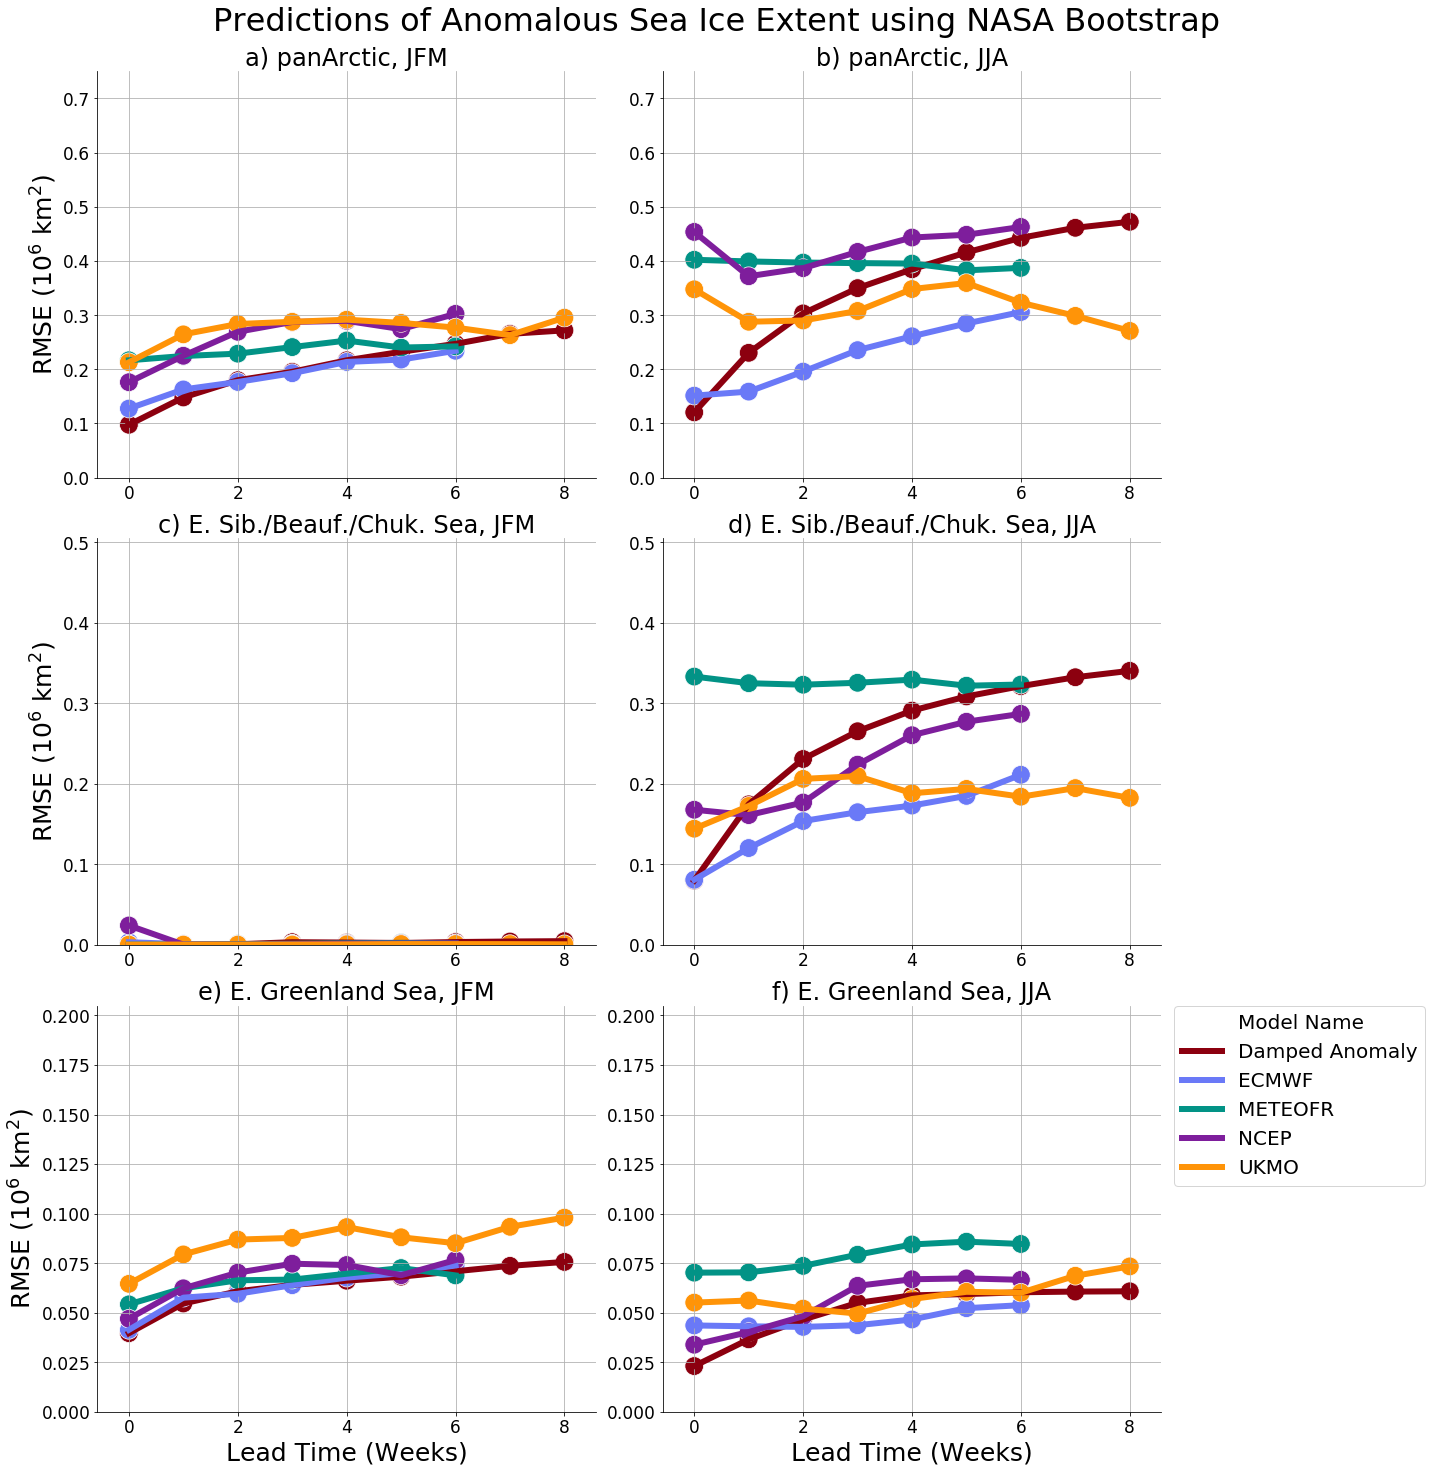

In [10]:
nrows = 3
ncols = 2
no_regions = len(regions_sort)
panel_lett = ['a','b','c','d','e','f',
                 'g','h','i','j','k','l']
if TO_PLOT == 'SIE RMSE':
    vmax = [1.05,0.75,0.75,0.375,0.255,0.375,0.255]
else:
    vmax = [0.75,0.505,0.205,0.305,0.205,0.205,0.205]
vmin = 0
fig1,ax1 = plt.subplots(nrows,ncols,figsize=(20,20))
for i in range(0,no_regions*2):
    ax_sel = ax1.flat[i]
    i_reg = np.floor(i/2).astype(int)
    #i_reg = i
    reg_sel = regions_sort[i_reg]
    if np.mod(i,2) == 0:
        seas_str_sel = seas_str_ALL[0]
    else:
        seas_str_sel = seas_str_ALL[1]
    #if np.mod(i,2) == 0:
    data_sel = d_SIE_all_gb.xs((reg_sel,seas_str_sel)).reset_index()
    #elif np.mod(i,2) == 1:
     #   data_sel = d_SIE_all_gb2.xs((reg_sel)).reset_index()
    # Plot
    RMSE_plot(ax_sel,data_sel,reg_sel,TO_PLOT,i,vmin,vmax[i_reg],no_regions,ncols,nrows)
    ax_sel.set_title('{panel_lett}) {reg_sel}, {seas_sel}'.format(panel_lett=panel_lett[i],reg_sel=reg_sel,seas_sel=seas_str_sel),fontsize=24)
    if i == nrows*ncols-1:
        leg = ax_sel.legend(bbox_to_anchor=(1.025,1),loc=2,borderaxespad=0,fontsize=20)
        for legob in leg.get_lines():
            legob.set_linewidth(6.0)
    else:
        leg = ax_sel.legend()
        leg.remove()
#fig1.delaxes(ax=ax1.flat[7])        
fig1.tight_layout()

if TO_PLOT == 'SIE RMSE':
    fig1.suptitle('Predictions of Sea Ice Extent using {obs_name}'.format(obs_name=obs_name_plt),fontsize=32,y=1.02)
else:
    fig1.suptitle('Predictions of Anomalous Sea Ice Extent using {obs_name}'.format(obs_name=obs_name_plt),fontsize=32,y=1.02)
if ALL_DAYS == True:
    fpath_save1 = fpath_save+'ALL_DAYS_{save_str}_{seas_str1}_{seas_str2}_RMSE_only_{obs_name}.pdf'.format(save_str=save_str,seas_str=seas_str,
                                                        seas_str1=seas_str_ALL[0],seas_str2=seas_str_ALL[1],obs_name=obs_name)
elif ALL_DAYS == False:
    fpath_save1 = fpath_save+'noVRILE_DAYS_{save_str}_{seas_str1}_{seas_str2}_RMSE_only_{obs_name}.pdf'.format(save_str=save_str,seas_str=seas_str,
                                                    seas_str1=seas_str_ALL[0],seas_str2=seas_str_ALL[1],obs_name=obs_name)
fig1.savefig(fpath_save1,format='pdf',bbox_inches='tight')  
print(fpath_save1)

In [12]:
data_sel

,Model Name,lead days,SIE RMSE,SIE MAE,year out,SIE sdev,sample size,p-value,SIE anom RMSE,SIE anom MAE,p-value anom
0,Damped Anomaly,0.0,0.022824,0.018955,2006.5,0.141244,745200.0000,24.728920,0.023076,0.019186,22.698004
1,Damped Anomaly,1.0,0.037591,0.030106,2006.5,0.136965,745200.0000,14.703760,0.036556,0.029445,8.474671
2,Damped Anomaly,2.0,0.047853,0.037434,2006.5,0.129757,745200.0000,9.648822,0.046525,0.036039,2.312204
3,Damped Anomaly,3.0,0.054603,0.043044,2006.5,0.129814,745200.0000,7.115871,0.054976,0.042131,8.196482
4,Damped Anomaly,4.0,0.056475,0.045056,2006.5,0.129135,745200.0000,-11.202519,0.058751,0.046009,0.354352
5,Damped Anomaly,5.0,0.056864,0.044527,2006.5,0.125737,745200.0000,-27.916519,0.059395,0.045575,-13.105786
6,Damped Anomaly,6.0,0.058127,0.045221,2006.5,0.126084,745200.0000,-25.385165,0.060315,0.046496,-12.712582
7,Damped Anomaly,7.0,0.058655,0.045892,2006.5,0.124442,745200.0000,-21.318051,0.060665,0.046965,-9.626465
8,Damped Anomaly,8.0,0.058972,0.046252,2006.5,0.126202,745200.0000,-19.141796,0.060802,0.047161,-8.892278
9,ECMWF,0.0,0.166404,0.157938,2006.5,0.127134,162135.0000,54.516804,0.043572,0.032639,33.743541


In [15]:
d_SIE_all_gb.xs(('E. Sib./Beauf./Chuk. Sea','JJA','Damped Anomaly'))

,SIE RMSE,SIE MAE,year out,SIE sdev,sample size,p-value,SIE anom RMSE,SIE anom MAE,p-value anom
lead days,,,,,,,,,
0.0,0.079395,0.064302,2006.5,0.514692,745200.0,43.941763,0.079785,0.066967,44.738274
1.0,0.174244,0.136131,2006.5,0.462537,745200.0,106.599898,0.174505,0.140363,103.865268
2.0,0.232513,0.176732,2006.5,0.425254,745200.0,129.613709,0.230884,0.179974,116.940670
3.0,0.267688,0.199047,2006.5,0.398608,745200.0,137.132344,0.265343,0.202259,120.652788
4.0,0.294875,0.218058,2006.5,0.383724,745200.0,149.779183,0.291002,0.219681,127.852809
5.0,0.315122,0.231033,2006.5,0.376847,745200.0,160.446768,0.308637,0.229980,133.291801
6.0,0.329438,0.240990,2006.5,0.372543,745200.0,168.623253,0.321472,0.238791,137.784806
7.0,0.340961,0.249951,2006.5,0.367448,745200.0,175.705247,0.332494,0.246875,143.629229
8.0,0.349737,0.256667,2006.5,0.365202,745200.0,180.779300,0.340462,0.252924,147.006760
